# What is it?
pySODE is in principle YET ANOTHER(!!) a generalish-purpose nnumerical IVP solver with some symbollic elements. It has a lot of overlap with Mathematica's NDSolve- NDSolve obviously is way more powerful for solving general equations (including PDEs).  But symODE is good for a range of useful problems, and has (or will have) a few features that aren't easily reproduced in Mathematics.  Overall it is less of a 'black-box than NDSolve, for better or worse.

1. Can easily add explicit numerical code ( can in Mathematica too, but more hoops)
2. Can (shortly) integrate with tensorflow, bot for increased speed and to enable automatic differentiation.
3. The driving use case is ensembles of similar atoms interacting by long-range electric fields: large ensembles of states with long-range coupling

Other python ODE solving packages that are likely more approtriate for general use:

* https://github.com/neurophysik/jitcode,
* http://bjodah.github.io/pyodesys/latest/index.html

They both seem more powerful, could likely replace this package for even the desired purpose. However I only learned about them after writing this, and I haven't tried them. To my mind it does seem unlikely that they'll be easily extended to large scales or to automatic differentiation of the whole system as is possible with Tensorflow, but please let me know if I"m mistaken


# Example general usage

Mostly what it's written for though is to enable assembling/solving master-equation based systems in python. That will be covered in [Solving master equations using pySODE]




In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from pylab import *
from spylind import spyIVP as so
import sympy as sm
sm.init_printing()

## Projectile motion

$$\frac{dx}{dt} = vx$$
$$\frac{dy}{dt} = vy$$

$$\frac{dv_x}{dt} = g$$
$$\frac{dv_y}{dt} = 0$$

In [2]:
xS, yS, vxS, vyS = sm.symbols("x, y, v_x, v_y", real=True)
g= -10.0
dy_dtD = {xS:vxS, 
       yS:vyS,
       vxS:1,
       vyS:g }

Munch({'tSym': t, 'dimSyms': [], 'prop_state_syms': [x, y, v_x, v_y], 'stationary_state_syms': [], 'driving_syms': [], 'state_dep_syms': []})
state dependent functions should have signature [t, x, y, v_x, v_y]


c:\users\morgan\anaconda3\envs\spylind\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


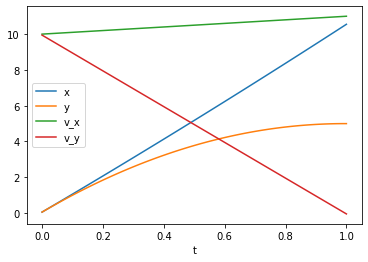

In [3]:
ode_s = so.ODESolver(dy_dtD,  dims={})
ode_s.set_initial_conditions({xS:0,yS:0,vxS:10,vyS:10}) 
ode_s.setup()
tSteps = linspace(0,1,100)
arr =ode_s.integrate(tSteps, 1.0)

plot(tSteps, arr)
xlabel('t')
legend(dy_dtD.keys())

## An ensemble of similar projectiles

Munch({'tSym': t, 'dimSyms': [z], 'prop_state_syms': [x, y, v_x, v_y], 'stationary_state_syms': [], 'driving_syms': [], 'state_dep_syms': [z]})
state dependent functions should have signature [t, z, x, y, v_x, v_y]


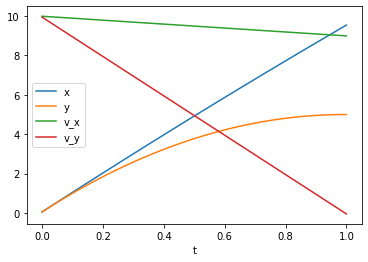

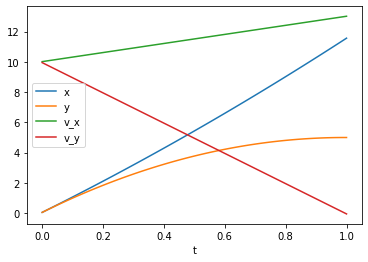

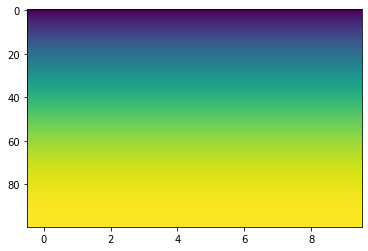

In [4]:
xS, yS, vxS, vyS = sm.symbols("x, y, v_x, v_y", real=True)
zS = sm.symbols("z", real=True)
g= -10.0
dy_dtD = {xS:vxS, 
       yS:vyS ,
       vxS:1 +zS,
       vyS: g  }

ode_s = so.ODESolver(dy_dtD,  dims={zS:linspace(-2,2,10)})
ode_s.set_initial_conditions({xS:0,yS:0,vxS:10,vyS:10}) 
ode_s.setup(bForceStateDimensions=True)
tSteps = linspace(0,1,100)
arr =ode_s.integrate(tSteps, 1.0)

plot(tSteps, arr[:,:,0].real)
xlabel('t')
legend(dy_dtD.keys())
figure()
plot(tSteps, arr[:,:,-1].real)
xlabel('t')
legend(dy_dtD.keys())
figure()
imshow(arr[:,1,:].real, aspect='auto')

## An ensemble of interacting projectiles (via a mutual attraction)

Munch({'tSym': t, 'dimSyms': [z], 'prop_state_syms': [x, y, v_x, v_y], 'stationary_state_syms': [], 'driving_syms': [], 'state_dep_syms': [k]})
state dependent functions should have signature [t, z, x, y, v_x, v_y]


Text(0, 0.5, 'y')

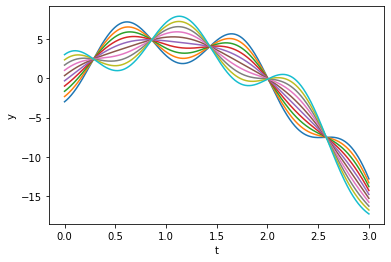

In [5]:
xS, yS, vxS, vyS, kS = sm.symbols("x, y, v_x, v_y, k", real=True)
zS = sm.symbols("z", real=True)
g= -10.0
dy_dtD = {xS:vxS, 
       yS:vyS,
       vxS:1,
       vyS: g + 30*kS }

ode_s = so.ODESolver(dy_dtD,  dims={zS:linspace(-2,2,10)})
ode_s.set_initial_conditions({xS:0*ones(10),yS:linspace(-3,3,10),vxS:10*ones(10),vyS:10*ones(10) }) 
def couplingF(t, dimAxes, state, driving_vals):
    x,y,vx,vy = state
    return y.mean()-y
ode_s.set_state_dep_funcs({kS:couplingF})

ode_s.setup(bForceStateDimensions=True)
tSteps = linspace(0,3,1000)
arr =ode_s.integrate(tSteps, 1.0)

plot(tSteps, arr[:,1,:].real)
xlabel('t')
ylabel('y')

